In [370]:
import numpy as np
import control
import pandas as pd
import matplotlib.pyplot as plt

In [371]:
# Load matrices from CSV
A_d = pd.read_csv('data/statespace_models/A_discrete.csv', header=None).values
B_d = pd.read_csv('data/statespace_models/B_discrete.csv', header=None).values
C_d = pd.read_csv('data/statespace_models/C_discrete.csv', header=None).values
D_d = pd.read_csv('data/statespace_models/D_discrete.csv', header=None).values

# Load dt from text file
with open('data/statespace_models/dt_discrete.txt', 'r') as f:
    dt = float(f.read().strip())

# Create the discrete system
sys_d = control.ss(A_d, B_d, C_d, D_d, dt)

In [372]:
# Load observer gains
L_c = pd.read_csv('data/gain_matrices/L_Continuous.csv', header=None).values
L_d = pd.read_csv('data/gain_matrices/L_Discrete.csv', header=None).values

# Load controller gains
K_c = pd.read_csv('data/gain_matrices/K_Continuous.csv', header=None).values
K_d = pd.read_csv('data/gain_matrices/K_Discrete.csv', header=None).values

In [373]:
# Load ekf Q and R
Qn = pd.read_csv('data/nonlinear_matrices/Qn.csv', header=None).values
Rn = pd.read_csv('data/nonlinear_matrices/Rn.csv', header=None).values

# Nonlinear Controller Simulation

In [374]:
# Initial State
x0 = np.array([0.0, 0.0, 0.1, 0.1])

In [375]:
dt = sys_d.dt
T_d = np.arange(0, 10, dt)
t_eval_d = T_d

## Extended Kalman Filter

<p align="center">
  <img src="Diagrams/EKF/EKF.png" alt="Alt text" width="600" height="500"/>
</p>


In [376]:
from utils import ekf_simulation_nonlinear_discrete,ekf_simulation_nonlinear_discrete_v1
# Run simulation
measurement_noise_std = np.array([0.01, 0.01, 0.1, 0.1])
disturbance_std = np.array([0.0, 0.00, 0.01, 0.01])
t_impulse = 3
impulse_magnitude = np.array([0.00, 0.05, 0.2, 0.2])
P0 = np.diag([
    1,  # position variance (m^2)
    1,  # velocity variance (m/s)^2
    1,  # angle variance (rad^2)
    1   # angular velocity variance (rad/s)^2
])

T_ekf_d, x_true_ekf_d, x_hat_ekf_d, tau_ekf_d = ekf_simulation_nonlinear_discrete(
    x0, P0, K_d,t_eval_d, Qn, Rn,
    measurement_noise_std=measurement_noise_std,
    disturbance_std=disturbance_std,
    t_impulse=None,
    impulse_magnitude=None,
    low_pass_enabled=False,
    debug_enabled=False)

K:[[ 0.10045949 10.08750993 12.59321803  2.54164549]]
K:[0.  0.  0.1 0.1]
u_filtered:-1.513486352313599
[[ 9.99000999e-01  4.98989020e-06  3.99425206e-08 -2.12914068e-10]
 [ 4.98989020e-06  9.99000999e-01 -7.99669233e-06  4.26264610e-08]
 [ 3.99425206e-09 -7.99669233e-07  9.99895599e-01  2.10133612e-05]
 [-2.12914068e-11  4.26264610e-09  2.10133612e-05  9.99899804e-01]]
[[ 4.99753296e-01  1.23578343e-03  4.98158758e-06  4.44693515e-07]
 [ 1.23578343e-03  5.05926846e-01 -1.99167074e-03 -1.77791308e-04]
 [ 4.98158758e-07 -1.99167074e-04  4.95057969e-01  4.65605851e-02]
 [ 4.44693515e-08 -1.77791308e-05  4.65605851e-02  5.59498916e-01]]
[[ 3.33230669e-01  1.63996289e-03  2.17673819e-06  3.14194702e-07]
 [ 1.63996289e-03  3.46797475e-01 -1.74113325e-03 -2.42507528e-04]
 [ 2.17673819e-07 -1.74113325e-04  3.27345183e-01  4.67968563e-02]
 [ 3.14194702e-08 -2.42507528e-05  4.67968563e-02  4.52301573e-01]]
[[ 2.49951682e-01  1.84475122e-03 -3.25139392e-07 -3.41854598e-08]
 [ 1.84475122e-03  2.7

0.999999, -0.003000, -0.000010, 0.000000 | -0.003000, 0.999999, 0.003315, -0.000012 | -0.000010, 0.003315, 1.011594, -0.107705 | 0.000000, -0.000012, -0.107705, 1.000637


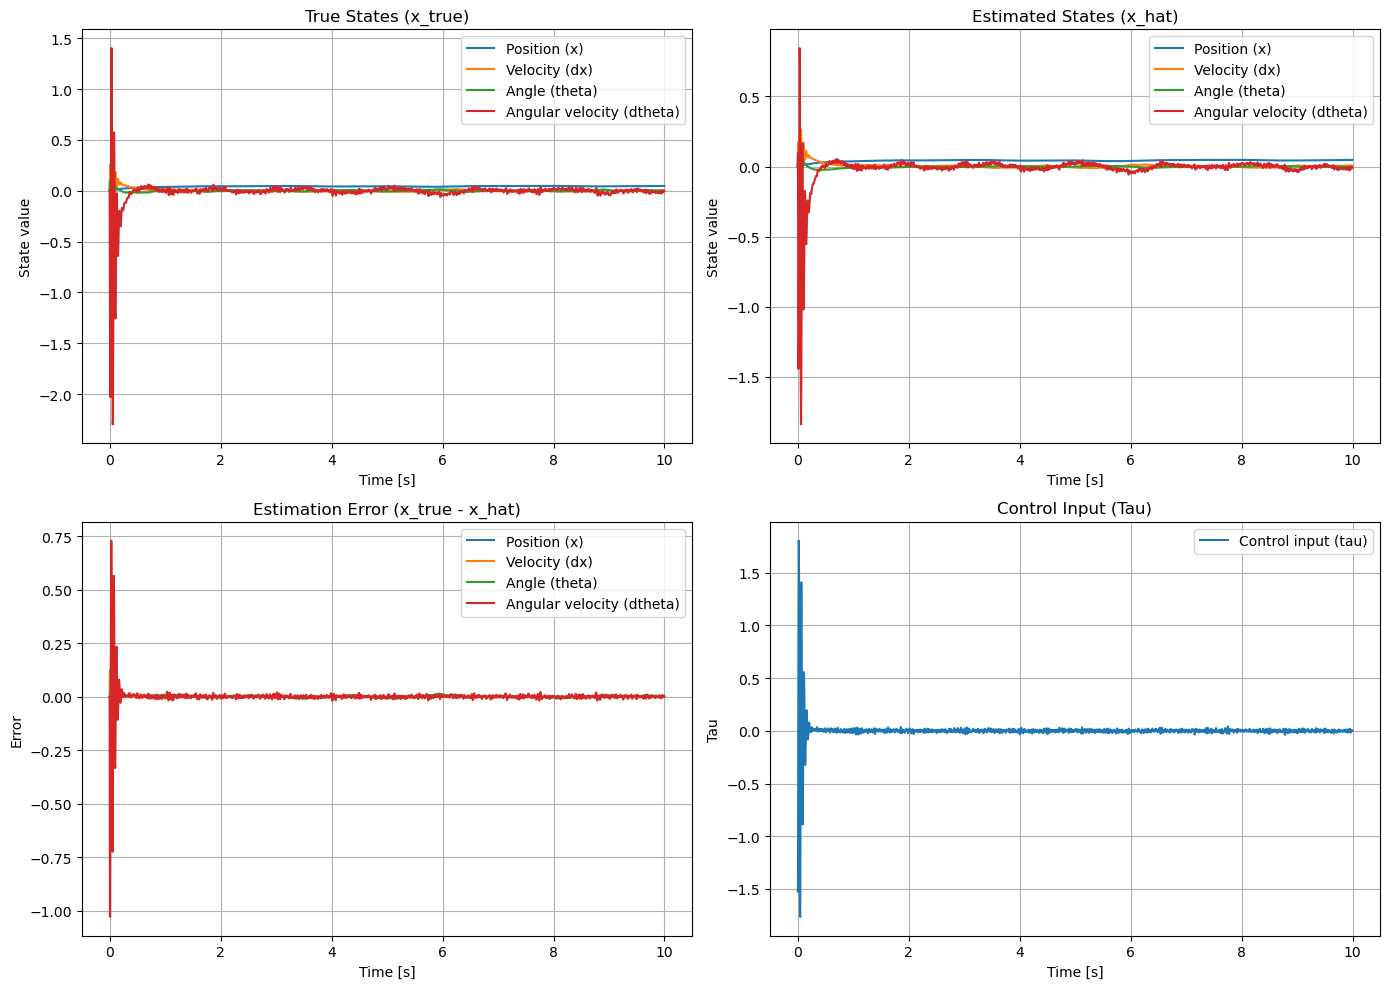

In [377]:
state_labels = ['Position (x)', 'Velocity (dx)', 'Angle (theta)', 'Angular velocity (dtheta)']

plt.figure(figsize=(14, 10))

# True states
plt.subplot(2, 2, 1)
for i in range(4):
    plt.plot(T_ekf_d, x_true_ekf_d[i], label=state_labels[i])
plt.title('True States (x_true)')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Estimated states
plt.subplot(2, 2, 2)
for i in range(4):
    plt.plot(T_ekf_d, x_hat_ekf_d[i], label=state_labels[i])
plt.title('Estimated States (x_hat)')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Estimation error
plt.subplot(2, 2, 3)
for i in range(4):
    plt.plot(T_ekf_d, x_true_ekf_d[i] - x_hat_ekf_d[i], label=state_labels[i])
plt.title('Estimation Error (x_true - x_hat)')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Control input
plt.subplot(2, 2, 4)
plt.plot(T_ekf_d, tau_ekf_d, label='Control input (tau)')
plt.title('Control Input (Tau)')
plt.xlabel('Time [s]')
plt.ylabel('Tau')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


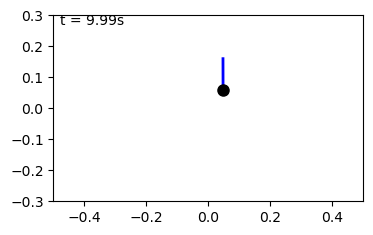

In [378]:
from utils import animate_inverted_pendulum
animate_inverted_pendulum(x_pos=x_true_ekf_d[0], theta = x_true_ekf_d[2], time =t_eval_d)